# Projeto 1 - Ciência dos Dados

Nome: Alison Araujo

Nome: Gabrielly Carneiro

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [140]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from unidecode import unidecode
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('word_tokenize')
stopwordsdic = stopwords.words('portuguese')

from spacy import load
nlp = load('pt_core_news_md')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading word_tokenize: Package 'word_tokenize' not
[nltk_data]     found in index


In [141]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
c:\Users\gabri\OneDrive - Insper - Institudo de Ensino e Pesquisa\Projeto 1\C.DadosP1


Carregando a base de dados com os tweets classificados manualmente:

In [142]:
train = pd.read_excel('dados_treino.xlsx')
train.head(5)

,Mensagem,Acionável/Direcionável/Não Acionável
0,"Para quem gosta de poemas simples, esse é o li...",N
1,Quando vi o lançamento pensei que finalmente p...,D
2,"É incrível como esses escritores e ""intelectua...",N
3,"Se desse pra devolver eu devolvia, nao é por e...",N
4,"Futilidade, inutilidade, desperdício de papel,...",N


In [143]:
test = pd.read_excel('dados_teste.xlsx')
test.head(5)

,Mensagem,Acionável/Direcionável/Não Acionável
0,"O livro é prolixo, redundante, doentio. Sou su...",N
1,"Bom livro e história envolvente. Porém, o leit...",D
2,"Fala tudo que todos já sabem, sem falar que nã...",N
3,Ganhei na compra do Kindle. Não é estilo de li...,N
4,"Custa crer que um livro tão medíocre, embora m...",N


___
## Classificador automático


O objetivo do seguinte projeto é desenvolver um classificador de texto automático a partir das hipóteses de Naive-Bayes. Para isso, o classificador será treinado com uma base de dados de reviews de livros vendidos pela Amazon, e sua performance será testada ao classificar mensagens de uma base de teste. Para isso, o projeto foi dividido nas seguintes etapas:

* Coleta de dados: o primeiro passo foi coletar os reviews dos livros em planilhas de treino (avaliações que serviram como base para o treino do classificador) e de teste (avaliações que verificam a acurácia do classificador);

* Classificação manual: a partir dos dados extraídos, foi feita a classificação manual de cada review, tanto da base de treino quanto de teste, considerando-se três possíveis classes/targets: Acionável, Direcionável e Não Acionável. Os critérios para essa classificação manual estão resumidos abaixo:
    - Acionável: para ser considerado "acionável" ("A") o review deve ser passível de alguma ação pela Amazon, ou seja, o review deve ser sobre entrega, estado do produto, contato com o suporte, etc;
    - Direcionável: para o target "direcionável" ("D") foram considerados comentários relativos à editora, como qualidade do material do livro, preço do livro e do e-book, tradução e edição;
    - Não Acionáveis: por fim, os não acionáveis ("N") eram comentários relativos ao autor, ao apreço pelo conteúdo do livro, ou comentários irrelavantes;

* Montando um classificador Naive-Bayes: para montar o classificador consideramos verdadeira a hipótese de Naive-Bayes: as probabilidades de ocorrência de cada palavra dentro de uma classe são independentes e a ordem das palavras dentro da frase não importa. Além disso, nessa etapa foram criadas as funções para calcular as probabilidades de cada frase ocorrer em uma classe. Dentro dessas funções utilizamos conceitos de probabilidade condicional e de suavização de LaPlace, que serão explicados a seguir;

* Verificando a performance do classificador: nesse tópico finalmente aplicamos o classificador automático: treinamos ele com a planilha "train", contento 500 reviews, e testamos sua performance para classificar 250 reviews da planilha "test". 

Ao final, traremos conclusões a respeito da performance do classificador em diferentes cenários, bem como gráficos apresentando a qualidade do classificador a partir de novas separações de base de teste e treino.  

#### Probabilidade condicional

Para classificar as frases em cada categoria, devemos utilizar a fórmula de probabilidade condicional abaixo:

$$P(classe|frase) = \frac{P(frase|classe)*P(classe)}{P(frase)}$$

Como nosso objetivo é fazer um comparador, não será necessário encontrar a probabilidade de cada frase, pois independente da categoria essa probabilidade será a mesma. 

O cálculo de $P(frase|classe)$ será dado por:

$$\quad P(frase|classe) = 
P(pal_1|classe)\cdot P(pal_2|classe)\cdot P(pal_3|classe)\cdot P(pal_4|classe)\cdot ... \cdot P(pal_n|classe)$$

Por fim, teremos:


$$P(classe|frase) = \frac{P(pal_1|classe)\cdot P(pal_2|classe)\cdot P(pal_3|classe)\cdot P(pal_4|classe)\cdot ... \cdot P(pal_n|classe)*P(classe)}{P(frase)}$$





#### Suavização de LaPlace

Vimos acima que para o cálculo da probabilidade de uma frase (um review) estar contido em um target/classe é preciso saber a probabilidade de cada palavra estar contida naquele target. Contudo, isso pode ser um problema caso essa palavra não esteja contida na minha base de dados. Note que caso a palavra não exista no meu vocabulário, a probabilidade dela ocorrer em qualquer classe seria zero; isso faria com que a probabilidade da frase ocorrer também fosse nula, o que não é verdade. Para corrigir esse erro, utiliza-se uma ferramenta bastante útil, chamada suavização de LaPlace. Aplicaremos a suavização para todas as palavras do vocabulário e, principalmente, a aplicaremos quando o classificador encontrar palavras que não estejam contidas no vocabulário. 

A fórmula que nos permite aplicar a suavização de LaPlace para uma determinada categoria é dada por:


$$ P(palavra|classe) = \frac{n_{Palavra na Classe} + \\\alpha}{n_{Total de Palavras} + \\\alpha . n_{Total de Palavras Sem Repeticao}}$$

Sendo:
- $P(palavra|classe)$ é a probabilidade da palavra estar contida na classe
- $n_{Palavra na Classe}$ é o número de ocorrências daquela palavra na classe, isto é, sua frequência absoluta na classe
- $n_{Total de Palavras}$ é o número total de palavras que existem naquela classe
- $n_{Total de Palavras Sem Repeticao}$ é o número total de palavras sem repetição que existem naquela classe 
- $\\\alpha$ é o fator de suavização 




___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

Funções úteis:

In [144]:
#Criar uma função que transforma as frases da planilha em um texto só 
    #(Será útil para criar o dicionário com as palavras)

def transforma_em_string(coluna):
    texto = ''
    for linha in coluna:
        texto += linha + ' '
    return texto    

In [145]:
#Criar uma função que limpa todas as pontuações
#recebe um texto
#vou utilizar ela na função limpa tudo
def cleanup(text):
    punctuation = r'[´"\'!-.:?;$,/~^_=+*&¨%$#@|\{}()[\]]'
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    return text_subbed

In [146]:
#Cria uma função que limpa os espaços duplicados
#vou utilizar ela na função limpa tudo
def limpa_espaco(text):
    punctuation = r'[\n]'  # Adicione os caracteres desejados aqui
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    return text_subbed

In [147]:
#Criando uma função para remover emoji
#vou utilizar ela na função limpa tudo
def remove_emoji(text):
    text_without_emojis = unidecode(text)
    return text_without_emojis

In [148]:
#Criando a função de stopwords
#vou utilizar ela na função limpa tudo
#vai receber o texto limpo pelas outras funções
def stopwords(texto):
    palavras = word_tokenize(texto, language='portuguese') # Tokenize é analisar palavras individualmente, basicamente
    palavras_sem_stopword = []
    for palavra in palavras:
        if palavra not in stopwordsdic:
            palavras_sem_stopword.append(palavra)
    # Reúna as palavras sem stopwords em uma string novamente
    texto_sem_stopword = ' '.join(palavras_sem_stopword)
    return texto_sem_stopword

In [149]:
#Criando a função de lematização
#vou utilizar ela na função limpa tudo
#vai receber o texto limpo pelas outras funções, incluindo limpeza de stopwords

def lemmat(texto):
    doc = nlp(texto)
    lemmat_radicais = []
    for radicais in doc:
        lemmat_radicais.append(radicais.lemma_)
    texto_lemmat = ' '.join(lemmat_radicais)    
    return texto_lemmat

In [150]:
# Cria uma função que reúna as funções de limpeza
def limpa_tudo(mensagem):
    #Aplicando a função de limpeza de pontuação
    texto = cleanup(mensagem)
    #Deixando tudo em letra minúscula
    texto = texto.lower()
    #Removendo emoji
    texto = remove_emoji(texto)
    #Aplicando a função de limpeza de espaço
    texto = limpa_espaco(texto)
    #Removendo stopwords
    texto = stopwords(texto)
    #Realiza lemmatização
    texto = lemmat(texto)  
    return texto

In [151]:
#Cria uma função que limpa as linhas da planilha e adiciona uma coluna com as mensagens limpas à planilha
def mensagem_limpa(planilha):   #recebe a planilha e cria uma nova planilha com a coluna de mensagem limpa com as frases limpas
    planilha_limpa = planilha.copy()
    planilha_limpa['Mensagem Limpa'] = [limpa_tudo(x) for x in list(planilha['Mensagem'])]
    return planilha_limpa    #retorna a planilha modificada

In [152]:
#Cria função que cria o vocabulário de tudo
def cria_vocabulario(coluna_mensagem_limpa_da_planilha_limpa):                       #recebe uma coluna da planilha
    lista_palavras = transforma_em_string(coluna_mensagem_limpa_da_planilha_limpa)
    lista_palavras = lista_palavras.split()
    return lista_palavras     #devolve uma lista com as palavras separadas

In [153]:
#Cria função que retorna uma lista sem as palavras repetidas
def remove_repeticao(lista_de_palavras):
    dic = set(lista_de_palavras)
    lista_vocabulario_sem_repeticao = list(dic)
    return lista_vocabulario_sem_repeticao

In [154]:
# Cria uma função que guarda as palavras em pd.Series e calculas frequencia (relativa e absoluta) das palavras
#recebe uma lista (devolvida pelo cria vocabulário, preferencialmente)
def cria_pdseries(lista):
    tabela = pd.Series(lista)
    return tabela

#Cria uma função que retorna a frequência absoluta de cada palavra no texto
#recebe uma tabela de pd
def freq_abs(tabela):
    absoluta = tabela.value_counts()
    return absoluta

#Cria uma função que retorna a frequência relativa de cada palavra no texto
def freq_rel(tabela):
    relativa = tabela.value_counts(True)
    return relativa

In [155]:
#Cria função de divisão com base nas categorias/targets
## Cria uma função que recebe a planilha e o target e 
# retorna o total de palavras e as tabelas de frequencia absoluta e relativa e o vocabulario sem palavras repetidas, nessa ordem
#vou falar que ela recebe a planilha limpa já

def divisao_categorias(planilha_limpa, target):
    #Etapa de divisão de categorias     
    #criou uma nova planilha apenas com as linha com aquele target                
    filtro_target = planilha_limpa.loc[planilha_limpa['Acionável/Direcionável/Não Acionável'] == target]
    vocab_target = cria_vocabulario(filtro_target["Mensagem Limpa"]) #vocabulario daquele target
    df_vocab_target = cria_pdseries(vocab_target)
    freq_rel_target = freq_rel(df_vocab_target)
    freq_abs_target = freq_abs(df_vocab_target)   #frequencia de palavras daquele target
    total_target = freq_abs_target.sum()  #total de palavras daquele target
    #criar vocabulario limpo
    vocab_target_sr = remove_repeticao(vocab_target)   #vocabulario do target sem palavras repetidas
    return total_target, freq_abs_target, freq_rel_target, vocab_target_sr

In [156]:
# Função que realiza a divisão de toda a planilha 
# # Função que recebe a planilha já limpa e retorna:
# o total de palavras com repetição [0] (int)
# a tabela com a frequência absoluta de cada palavra na planilha [1] (Series)
# a tabela com a frequência relativa de cada palavra na planilha [2] (Series)
# a lista com todas as palavras da planilha sem repetição [3] (list)
def divisao_planilhas(planilha_limpa):
    
    coluna_limpa = planilha_limpa["Mensagem Limpa"]                   #separa só a coluna "Mensagem Limpa"
    vocab_planilha = cria_vocabulario(coluna_limpa)             #lista de palavras na coluna "Mensagem Limpa"
    df_vocab_planilha = cria_pdseries(vocab_planilha)       #coloca essa lista em um df
    freq_abs_planilha = freq_abs(df_vocab_planilha)         #calcula a frequência absoluta de cada palavra
    freq_rel_planilha = freq_rel(df_vocab_planilha)         #calcula a frequência relativa de cada palavra
    total_planilha = freq_abs_planilha.sum()                #calcula o total de palavras com repetição
    vocab_planilha_sr = remove_repeticao(vocab_planilha)       #vocabulario sem repeticao (é uma lista)

    return total_planilha, freq_abs_planilha, freq_rel_planilha, vocab_planilha_sr


In [157]:
# Função que cria um dicionário com as palavras e as frequencias absolutas

#vou criar um dicionário com todas as palavras e seus valores de 
# frequencia absoluta para cada target
# aí vai ficar mais rapido de encontrar os valores
# do que ter que suavizar pra cada palavra toda vez
# que chamar o loop
def dicionario_prob_palavra_dado_target_treino(planilha_treino_limpa, target):
    coluna_limpa = planilha_treino_limpa["Mensagem Limpa"]
    dados_target = divisao_categorias(planilha_treino_limpa, target)
    # frequencias_relativas = dados_target[2]
    frequencias_absolutas = dados_target[1]

    dic_treino = {} 
    
    for frase in coluna_limpa:
        frase = frase.split()
        for palavra in frase:
            if palavra not in dic_treino:
                if palavra in frequencias_absolutas:
                    freq_abs_palavra = frequencias_absolutas[palavra]
                    dic_treino[palavra] = freq_abs_palavra
    return dic_treino

In [158]:
# Função que calcula probabidade da frase dado target realizando suavização de LaPlace
# Probabilidade da frase dado target mais suavização de LaPlace
def frase_dado_target(frase_do_teste, target, planilha_treino_limpa):
    prob_frase_dado_classe = 1
    frase_do_teste =  frase_do_teste.split()
    dic_probabilidades_por_classe_treino = dicionario_prob_palavra_dado_target_treino(planilha_treino_limpa, target)   #dicionario com as palavras e suas frequencias absolutas
    dados_target = divisao_categorias(planilha_treino_limpa, target)
    qtdd_palavras = dados_target[0]                  #quantidade de palavras no target informado
    qtdd_palavras_sem_repeticao = len(dados_target[3]) 
    
    alfa = 0.01
    for palavra in frase_do_teste:
        if palavra in dic_probabilidades_por_classe_treino:
            freq_abs_palavra = dic_probabilidades_por_classe_treino[palavra]
            #APLIQUEI A SUAVIZAÇÃO DE LA PLACE
            prob_palavra_dado_classe = (freq_abs_palavra + alfa)/(qtdd_palavras + alfa*qtdd_palavras_sem_repeticao)
            prob_frase_dado_classe *= prob_palavra_dado_classe
        else:
            freq_abs_palavra = 0
            #APLIQUEI A SUAVIZAÇÃO DE LA PLACE
            prob_palavra_dado_classe = (freq_abs_palavra + alfa)/(qtdd_palavras + alfa*qtdd_palavras_sem_repeticao)
            prob_frase_dado_classe *= prob_palavra_dado_classe
    return prob_frase_dado_classe

In [159]:
#Função de classificação das frases (quanto a acionável, não acionável e direcionável)
#recebe a planilha já limpa
def classificador(frase_do_teste, planilha_treino):
    
    #Extraindo as informações
    total_planilha_N = divisao_categorias(planilha_treino, "N")[0]
    total_planilha_D = divisao_categorias(planilha_treino, "D")[0]
    total_planilha_A = divisao_categorias(planilha_treino, "A")[0]
    total_planilha = divisao_planilhas(planilha_treino)[0]
    
    #Cálculo das probabilidades
    P_frase_dado_A = frase_dado_target(frase_do_teste, "A", planilha_treino)
    P_frase_dado_D = frase_dado_target(frase_do_teste, "D", planilha_treino)
    P_frase_dado_N = frase_dado_target(frase_do_teste, "N", planilha_treino)
    P_N = total_planilha_N/total_planilha         #probabilidade de estar na categoria N
    P_D = total_planilha_D/total_planilha         #probabilidade de estar na categoria D
    P_A = total_planilha_A/total_planilha         #probabilidade de estar na categoria A
    
    P_A_dado_frase = P_frase_dado_A*P_A
    P_N_dado_frase = P_frase_dado_N*P_N
    P_D_dado_frase = P_frase_dado_D*P_D
        
    #Classificação
    if P_A_dado_frase >= P_D_dado_frase and P_A_dado_frase >= P_N_dado_frase:    #na classificação manual quando impatava a prioridade era acionável
        return "A"
    elif P_D_dado_frase > P_N_dado_frase and P_D_dado_frase > P_A_dado_frase:
        return "D"
    elif P_N_dado_frase > P_D_dado_frase and P_N_dado_frase > P_A_dado_frase:
        return "N"
    else:
        return "Houve um impasse"    
    

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [160]:
# Função que classifica todas as mensagens da planilha de teste com base na planilha de treino
#Fazer meu classificador classificar todas as frases da planilha de teste
#recebe a planilha inteira, não precisa realizar nenhuma limpeza
def classifica_planilha(planilha_teste, planilha_treino):
    planilha_teste_limpa = mensagem_limpa(planilha_teste)
    planilha_treino_limpa = mensagem_limpa(planilha_treino)
    avaliacoes_limpas = planilha_teste_limpa["Mensagem Limpa"]
    #fez uma cópia da planilha para nao alterar a antiga
    planilha_nova = planilha_teste_limpa.copy()
    # Criar uma lista para armazenar os resultados do classificador
    resultados = []
    for frase in avaliacoes_limpas:
        resultado = classificador(frase, planilha_treino_limpa)
        resultados.append(resultado)
    # Atribuir a lista de resultados à coluna 'Classificador Automático'
    planilha_nova['Classificador Automático'] = resultados
    return planilha_nova

In [161]:
#Função que faz as comparações de acurácia e classificação das mensagens
def divide_comparativos(planilha_treino, planilha_teste):

    planilha = classifica_planilha(planilha_teste, planilha_treino)
    comparador = pd.crosstab(planilha['Classificador Automático'], planilha['Acionável/Direcionável/Não Acionável'],normalize=True, margins=True)
    acuracia = comparador.iloc[0]['A'] + comparador.iloc[1]['D'] + comparador.iloc[2]['N'] 

    pct_falsos_A = comparador.iloc[0]['D'] + comparador.iloc[0]['N']
    pct_falsos_D = comparador.iloc[1]['A'] + comparador.iloc[1]['N']
    pct_falsos_N = comparador.iloc[2]['D'] + comparador.iloc[2]['A']
    pct_verdadeiros_A = comparador.iloc[0]['A']
    pct_verdadeiros_D = comparador.iloc[1]['D']
    pct_verdadeiros_N = comparador.iloc[2]['N'] 

    return acuracia*100, pct_falsos_A*100, pct_falsos_D*100, pct_falsos_N*100, pct_verdadeiros_A*100, pct_verdadeiros_D*100, pct_verdadeiros_N*100, comparador

resultados = divide_comparativos(train,test)

verdadeiros_positivos = resultados[0]
falsos_acionaveis = resultados[1]
falsos_direcionaveis = resultados[2]
falsos_nao_acionaveis = resultados[3]
verdadeiros_acionaveis = resultados[4]
verdadeiros_direcionaveis = resultados[5]
verdadeiros_naoacionaveis = resultados[6]
df_crosstab = resultados[7]

In [162]:
#printando resultados
print("A acurácia foi {0:.2f}% (mensagens corretamente classificadas)".format(verdadeiros_positivos))
print("A procentagem de falsos acionáveis foi {0:.2f}% (mensagens incorretamente classificadas como acionáveis)".format(falsos_acionaveis))
print("A procentagem de falsos direcionáveis foi {0:.2f}% (mensagens incorretamente classificadas como direcionáveis)".format(falsos_direcionaveis))
print("A procentagem de falsos não acionáveis foi {0:.2f}% (mensagens incorretamente classificadas como não acionáveis)".format(falsos_nao_acionaveis))
print("A procentagem de verdadeiros acionáveis foi {0:.2f}% (mensagens corretamente classificadas como acionáveis)".format(verdadeiros_acionaveis))
print("A procentagem de verdadeiros direcionáveis foi {0:.2f}% (mensagens corretamente classificadas como direcionáveis)".format(verdadeiros_direcionaveis))
print("A procentagem de verdadeiros não acionáveis foi {0:.2f}% (mensagens corretamente classificadas como não acionáveis)".format(verdadeiros_naoacionaveis))
#cruzamento de dados da planilha
df_crosstab

A acurácia foi 83.20% (mensagens corretamente classificadas)
A procentagem de falsos acionáveis foi 8.00% (mensagens incorretamente classificadas como acionáveis)
A procentagem de falsos direcionáveis foi 6.00% (mensagens incorretamente classificadas como direcionáveis)
A procentagem de falsos não acionáveis foi 2.80% (mensagens incorretamente classificadas como não acionáveis)
A procentagem de verdadeiros acionáveis foi 11.20% (mensagens corretamente classificadas como acionáveis)
A procentagem de verdadeiros direcionáveis foi 12.80% (mensagens corretamente classificadas como direcionáveis)
A procentagem de verdadeiros não acionáveis foi 59.20% (mensagens corretamente classificadas como não acionáveis)


Acionável/Direcionável/Não Acionável,A,D,N,All
Classificador Automático,,,,
A,0.112,0.036,0.044,0.192
D,0.032,0.128,0.028,0.188
N,0.000,0.028,0.592,0.620
All,0.144,0.192,0.664,1.000


___
### Concluindo

* Conclusões Gerais 

A acurácia do classificador automático para essas base de treino e teste foi de 83.2%. 

A partir da análise qualitativa dos percentuais de acertos obtidos no item Verificando a Performance do Classificador, podemos concluir que o melhor desempenho do classificador ocorre na categoria "Não Acionável", com a maior porcentagem de acertos na classificação, e menor porcentagem de erros (4,72% de erro em relação a quantidade de acertos nessa categori).

Para a categoria direcionáveis, o percentual de erros comparados ao percentual de acertos foi de aproximandamente 47%, o que representa uma certa dificuldade do classificador para identificar essas frases.

O pior desempenho, no entanto, ocorre para a categoria Acionáveis, visto que o percentual de acertos é bastante comparável ao percentual de erros (o percentual de erros representa cerca de 71.43% dos acertos). Ou seja, se o objetivo principal do classificador é direcionar mensagens acionáveis para a Amazon, seu desempenho não se mostra tão satisfatório, ainda que para esse caso nenhuma frase Acionável foi considerada irrelevante (Não Acionável).

Contudo, podemos pensar em outras estratégias para a melhoria do nosso classificador. Por exemplo, notamos abaixo que o classificador consegue tratar adequadamente frases com dupla negação ou com sarcasmos, mas não consegue diferenciar tão bem as categorias Acionável e Direcionável. Uma ideia para a expansão e nova iteração para esse projeto seria treiná-lo mais uma vez com as frases Acionáveis e Direcionáveis: ou seja, realizar duas classificações. Na primeira, manteríamos as três classificações (A, D e N). Em seguida, poderíamos descartar as frases classificadas como Não Acionáveis (que apresentam pequeno percentual de erro). Por fim, realizaríamos novo treinamento somente considerando as frases Acionáveis e Direcionáveis, para então reclassificar as frases como A ou D. Para isso, seria necessário, também, ampliar a base de dados a fim de obter mais referências para o treino do classificador.

Ou seja, embora o classificador ainda apresente erros consideráveis nas classificações, sua expansão poderia levar a melhorias significativas nos resultados, mostrando-se uma ferramenta útil para a Amazon direcionar reclamações ou tomar medidas para o atendimento do consumidor. De todo modo, mesmo sem uma nova iteração o classificador funciona como um bom filtro para descartar mensagens "não acionáveis", ou seja, elimina avaliações irrelevantes para a empresa.

#### Análise Qualitativa

Pensando em apurar a performance do classificador, propomos aqui a análise qualitativa do desempenho do classificador automático em diferentes cenários.


* Primeiro cenário: análise de frases ambíguas

Nesse primeiro caso, temos a intenção de analisar o comportamento do classificador diante de mensagens que podem ser ambíguas, ou seja, poderiam ser classificadas tanto como acionáveis, quanto como direcionáveis.

Frase: "As páginas desse livro têm uma péssima qualidade, são extremamente finas e fáceis de rasgar. Além disso o box chegou todo rasgado e a entrega foi demorada"

Essa frase deveria ser classificada como Acionável, visto que durante a classificação manual as reclamações quanto à amazon (acionáveis) deveriam ter prioridade. Vamos então verificar o que acontece com ela quando utilizamos nosso classificador:

In [183]:
#Como a função classificador recebe a planilha com as mensagens limpas, vamos realizar essa limpeza para todas as estapas abaixo
planilha_limpa = mensagem_limpa(train)

In [164]:
frase1 = "As páginas desse livro têm uma péssima qualidade, são extremamente finas e fáceis de rasgar. Além disso o box chegou todo rasgado e a entrega foi demorada"
#como a frase precisa estar limpa, realizamos as limpezas do texto:
#vou criar uma pequena função para classificar rapidamente as frases
def classifica_frase(frase, planilha_limpa):
    frase = limpa_tudo(frase)
    classificacao = classificador(frase, planilha_limpa)
    return classificacao

print("A frase foi classificada como {0}".format(classifica_frase(frase1, planilha_limpa)))


A frase foi classificada como D


Como podemos observar, a frase foi classificada como Direcionável, o que representa uma incoerência do nosso classificador. Vamos então realizar alguns testes, como remoção de palavras, para avaliar se nosso classificador interpreta de outra maneira.

Frase = "Esse livro têm uma péssima qualidade. Além disso o box chegou todo rasgado e a entrega foi demorada"

In [165]:
frase1 = "Esse livro têm uma péssima qualidade. Além disso o box chegou todo rasgado e a entrega foi demorada"
print("A frase foi classificada como {0}".format(classifica_frase(frase1, planilha_limpa)))

A frase foi classificada como D


Novamente, a classificação foi incorreta. Realizando uma nova iteração:

Frase = "Péssima qualidade. Além disso o box chegou todo rasgado e a entrega foi demorada"

In [166]:
frase1 = "Péssima qualidade. Além disso o box chegou todo rasgado e a entrega foi demorada"
print("A frase foi classificada como {0}".format(classifica_frase(frase1, planilha_limpa)))

A frase foi classificada como D


Aqui, percebemos que apesar de não haver nenhuma citação direta quanto à qualidade das páginas ou da edição, ainda assim a frase foi classificada como Direcionável. Vamos, por fim, remover qualquer menção à qualidade:

Frase = "O box chegou todo rasgado e a entrega foi demorada"

In [167]:
frase1 = "O box chegou todo rasgado e a entrega foi demorada"
print("A frase foi classificada como {0}".format(classifica_frase(frase1, planilha_limpa)))

A frase foi classificada como A


Somente nessa frase ela foi corretamente classificada. Ou seja, notamos que nosso classificador apresenta uma falha ao diferenciar frases com ambiguidade, que deveriam, por prioridade da classificação manual, ser classificadas como Acionável (para a Amazon). 

Uma das principais hipóteses para explicar essa falha é a de que a base de treino do nosso classificador continha pouquíssimas frases que reclamavam tanto da editora quanto da Amazon, de modo que não foi possível treinar corretamente o classificador para distinguir essas informações.

Vamos agora analisar uma frase que poderia ser classificada como Não Acionável e como Acionável, como por exemplo:

Frase = "Esse livro não tem nada de interessante, história básica, personagens sem graça e descrições muito longas. Além disso, a entrega chegou atrasada e em péssimas condições"


In [168]:
frase = "Esse livro não tem nada de interessante, história básica, personagens sem graça e descrições muito longas. Além disso, a entrega chegou atrasada e em péssimas condições"
print("A frase foi classificada como {0}".format(classifica_frase(frase, planilha_limpa)))

A frase foi classificada como N


In [169]:
frase = "Esse livro não tem nada de interessante. Além disso, a entrega chegou atrasada e em péssimas condições"
print("A frase foi classificada como {0}".format(classifica_frase(frase, planilha_limpa)))

A frase foi classificada como D


In [170]:
frase = "Nada de interessante. Além disso, a entrega chegou atrasada e em péssimas condições"
print("A frase foi classificada como {0}".format(classifica_frase(frase, planilha_limpa)))

A frase foi classificada como D


In [171]:
frase = "A entrega chegou atrasada e em péssimas condições"
print("A frase foi classificada como {0}".format(classifica_frase(frase, planilha_limpa)))

A frase foi classificada como A


Como podemos perceber, o classificador de fato apresenta problemas em diferenciar frases com diferentes posíveis classificações. Além disso, ele classificou incorretamente a frase como Direcionável, enquanto deveria ter classificado como Acionável. 
Novamente, essa incoerência pode estar relacionada à pobreza da base de treino quanto à classificações Acionáveis e Direcionáveis. 

Fazendo uma breve análise quantitativa na distribuição de dados da planilha de treino, podemos observar a quantidade de classificações manuais como Acionável, Direcionável e Não Acionável. Veja na célula abaixo:

In [172]:
#cria uma pequena função para calcular as ocorrências de cada target na planilha
def filtro (planilha_limpa, target):
    filtro_target = planilha_limpa.loc[planilha_limpa['Acionável/Direcionável/Não Acionável'] == target]
    return len(filtro_target)

acionaveis = filtro(planilha_limpa, "A")
direcionaveis = filtro(planilha_limpa, "D")
naoacionaveis = filtro(planilha_limpa, "N")
total = acionaveis + direcionaveis + naoacionaveis
pct_a = acionaveis/total
pct_d = direcionaveis/total
pct_n = naoacionaveis/total

print("A porcentagem de frases manualmente classificadas foi:\nAcionáveis = {0:.2f}%\nDirecionáveis = {1:.2f}%\nNão Acionáveis = {2:.2f}%".format(pct_a*100,pct_d*100, pct_n*100))

A porcentagem de frases manualmente classificadas foi:
Acionáveis = 15.60%
Direcionáveis = 20.20%
Não Acionáveis = 64.20%


Ou seja, há mais referências para frases Não Acionáveis, em seguida Direcionáveis, e por último Acionáveis, o que pode ser uma boa explicação para as falhas do classificador quanto à distinção da classificação.

Analisaremos agora outro cenário

* Segundo cenário: análise de frases sarcásticas

Queremos agora analisar o comportamento do nosso classificador diante de frases sarcásticas, mas que poderiam ser classificadas de diferentes maneiras.

Frase: "Amei que meu box veio todo rasgado"

Essa frase deveria ser classificada como Acionável. Vamos verificar a classificação automática:

In [173]:
frase2 = "Amei que meu box veio todo rasgado"
print("A frase foi classificada como {0}".format(classifica_frase(frase2, planilha_limpa)))

A frase foi classificada como A


Essa frase foi corretamente interpretada. Vamos testar agora para outras frases irônicas com diferentes classificações:

Frase 1 = "A Amazon é ótima, ideal para quem gosta de receber os livros com atraso e com as embalagens mal feitas"

Frase 2 = "A Amazon é ideal para quem gosta de receber livros com páginas de péssima qualidade e com tradução mal feita"

Frase 3 = "O livro é ótimo para quem quer perder capacidade intelectual"

A frase 1 deve ser classificada como Acionável, a frase 2 deve ser classificada como Direcionável e a frase 3 como Não Acionável

In [174]:
frase_ironica_a = "A Amazon é ótima, ideal para quem gosta de receber os livros com atraso e com as embalagens mal feitas"
frase_ironica_d = "A Amazon é ideal para quem gosta de receber livros com páginas de péssima qualidade e com tradução mal feita"
frase_ironica_n = "O livro é ótimo para quem quer perder capacidade intelectual"
print("A Frase 1 foi classificada como {0}\nA Frase 2 foi classificada como {1}\nA Frase 3 foi classificada como {2}".format(classifica_frase(frase_ironica_a, planilha_limpa), classifica_frase(frase_ironica_d, planilha_limpa), classifica_frase(frase_ironica_n, planilha_limpa)))


A Frase 1 foi classificada como A
A Frase 2 foi classificada como D
A Frase 3 foi classificada como N


Com base nessas classificações, percebemos que as três frases foram corretamente classificadas.

Ou seja, podemos concluir que o classificador foi capaz de contornar a ironia contida nas frases! 

Uma das possíveis explicações para esse fato é de que, como o classificador analisa as palavras individualmente e remove algumas stopwords, uma reclamação quanto ao atraso ou quanto à entrega terá o mesmo efeito se acompanhada de palavras positivas (como ótimo, excelente, incrível) ou negativas (como péssimo, horrível). Vamos verificar essa suspeita?

Frase 1 = "A Amazon é ótima, ideal para quem gosta de receber os livros com atraso e com as embalagens mal feitas"

Frase 4 = "A Amazon é horrível, péssima para quem gosta de receber os livros sem atraso e sem as embalagens mal feitas"

Note que o sentido da frase se manteve. Será que o classificador irá classificá-las igualmente?

In [175]:
Frase_1 = "A Amazon é ótima, ideal para quem gosta de receber os livros com atraso e com as embalagens mal feitas"
Frase_4 = "A Amazon é horrível, péssima para quem gosta de receber os livros sem atraso e sem as embalagens mal feitas"
print("A Frase 1 foi classificada como {0}\nA Frase 4 foi classificada como {1}".format(classifica_frase(Frase_1, planilha_limpa), classifica_frase(Frase_4, planilha_limpa)))


A Frase 1 foi classificada como A
A Frase 4 foi classificada como A


Parece que o classificador realmente consegue contornar ironias contidas nas frases. Vamos então para o último cenário.

* Terceiro cenário: análise de frases com dupla negação

Queremos saber, por fim, se o classificador é capaz de interpretar corretamente frases com dupla negação. Isto é, diante da ocorrência frequente de uma palavra, ele consegue analisar seu verdadeiro sentido?

Tomemos como exemplo as seguintes frases:

Frase A = "Não entendo como não conseguem enviar no prazo e sem chegar tudo rasgado"

Frase D = "Não entendo como não conseguem fazer páginas com qualidade ou com uma tradução decente"

Frase N = "Não entendo como pode um autor tão famoso não ter o mínimo de conteúdo para apresentar"

A Frase A deverá ser classificada como Acionável, enquanto a Frase D deverá ser classificada como Direcionável e a frase N como Não Acionável. Vejamos o que o classificador indica:


In [176]:

frasea = "Não entendo como não conseguem enviar no prazo e sem chegar tudo rasgado"
frased = "Não entendo como não conseguem fazer páginas com qualidade ou com uma tradução decente"
frasen = "Não entendo como pode um autor tão famoso não ter o mínimo de conteúdo para apresentar"

classifica_frase(frase1, planilha_limpa)
print("A Frase A foi classificada como {0}\nA Frase D foi classificada como {1}\nA Frase N foi classificada como {2}".format(classifica_frase(frasea, planilha_limpa), classifica_frase(frased, planilha_limpa), classifica_frase(frasen, planilha_limpa)))


A Frase A foi classificada como A
A Frase D foi classificada como D
A Frase N foi classificada como N


Com base nesse resultado, o classificador automático também não parece apresentar problemas quanto à interpretação de frases com dupla negação. A isso provavelmente se deve o fato de a ocorrência da palavra não apresentar frequência relativa muito parecida nas três classes  (A, D e N). Vamos verificar isso quantitativamente:

In [177]:
#Frequencia relativa da palavra "não" em cada classificação

nao_em_a = divisao_categorias(planilha_limpa, "A")[2]["nao"]
nao_em_d = nao_em_a = divisao_categorias(planilha_limpa, "D")[2]["nao"]
nao_em_n = divisao_categorias(planilha_limpa, "N")[2]["nao"]

print('Frequência relativa de aparecimento da palavra "não" em classificações Acionáveis: {0:.5f}\nFrequência relativa de aparecimento da palavra "não" em classificações Direcionáveis: {1:.5f}\nFrequência relativa de aparecimento da palavra "não" em classificações Não Acionáveis: {2:.5f}'.format(nao_em_a, nao_em_d, nao_em_n))
    

Frequência relativa de aparecimento da palavra "não" em classificações Acionáveis: 0.03103
Frequência relativa de aparecimento da palavra "não" em classificações Direcionáveis: 0.03103
Frequência relativa de aparecimento da palavra "não" em classificações Não Acionáveis: 0.03952


Ou seja, a dupla negação não parece interferir na classificação final da frase. Ainda assim, vale ressaltar que esses são apenas alguns exemplos e não representam a totalidade dos casos.;

Uma análise mais fidedigna deveria ser realizada de maneira quantitativa. Porém, por ora, é possível concluir que nos casos de ironia e dupla negação o classificador funciona, apresentando real dificuldade apenas para distinguir frases com ambiguidade de dupla classificação.

* *Conclusões Gerais*

* *Outros Cenários*


Pensando na utilidade de um classificador Naive-Bayes, destacamos outras aplicações além de um classificador de frases: 

* Recomendação de oportunidades

Na disciplina de Codesign de Aplicativos no Insper, há um projeto de desenvolvimento de um aplicativo comercializável. Um dos projetos consiste no desenvolvimento de um app que irá recomendar oportunidades profissionais e acadêmicas relevantes para um usuário, baseado no seu perfil de interesses. Nesse contexto, a recomendação de conteúdo baseada em um classificador Naive-Bayes seria uma ótima aplicação da ferramenta. Para isso deveríamos considerar que cada interesse e oportunidade são independentes entre si (o que não é necessariamente verdade, mas é uma boa aproximação). Assim, poderíamos calcular a P(Oportunidade|Interesses), que seria a probabilidade de uma oportunidade ser relevante para a pessoa dado os interesses que ela declarou. Nesse caso, cada "interesse" receberia um rótulo, e haveria uma probabilidade desse rótulo ocorrer no perfil daquela pessoa (etapa de coleta de dados). Cada "oportunidade" também seria um rótulo, mas com uma probabilidade (ocorrência) dentro do app (novamente, coleta de dados). Precisaríamos, ainda, treinar o classificador para identificar quais oportunidades são relevantes para os interesses declarados de cada pessoa. Dessa maneira, poderíamos quantificar os interesses do usuário e recomendar oportunidades mais relevantes com base em seus interesses. Isso é uma boa aplicação para direcionar conteúdos específicos para cada perfil de usuário. 

(Ideia matemática: P(Oportunidade|Interesses) = P(Interesses|Oportunidade)*P(Oportunidade)/P(Interesses))


* Previsão do tempo simples

Uma outra aplicação para o classificador Naive-Bayes seria um sistema simplificado de previsão do tempo com base em dados anteriores. Se a base de dados anteriores contiver informações como umidade e temperatura e a condição meteorológica daquele dia (por exemplo, sol, chuva ou nublado), será possível treinar o classificador para prever o tempo de um dia com base na umidade e temperatura coletadas. Isto é: calcularíamos P(Sol|Umidade e Temperatura) = P(Umidade e Temparatura|Sol)*P(Sol)/P(Umidade e Temperatura). Contudo, como iremos comparar P(Sol|Umidade e Temperatura) com P(Chuva|Umidade e Temperatura) e P(Nublado|Umidade e Temperatura), não precisaríamos do fator P(Umidade e Temperatura). Logo, poderíamos indicar qual a condição climática de maior probabilidade para cada dia (ou melhor, para cada par de umidade e temperatura). Portanto, embora as previsões climáticas considerem muitos outros fatores, a aplicação de Naive-Bayes para uma previsão simplificada faz bastante sentido.









___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [178]:
#Criar planilha com todas as avaliações (treino e teste)
train_test = pd.concat([train, test])

In [179]:
# Dividindo os dados em treinamento e teste usando a função train_test_split da biblioteca sklearn

acuracia = []
falsos_acionaveis = []
falsos_direcionaveis = []
falsos_nao_acionaveis = []
verdadeiros_acionaveis = []
verdadeiros_direcionaveis = []
verdadeiros_naoacionaveis = []

for i in tqdm(range(0,100),  desc="Progesso", unit="rows"):
    
    novo_treino, novo_teste = train_test_split(train_test, test_size=250, random_state=None)
    resultados = divide_comparativos(novo_treino, novo_teste)
    acuracia.append(resultados[0])
    falsos_acionaveis.append(resultados[1])
    falsos_direcionaveis.append(resultados[2])
    falsos_nao_acionaveis.append(resultados[3])
    verdadeiros_acionaveis.append(resultados[4])
    verdadeiros_direcionaveis.append(resultados[5])
    verdadeiros_naoacionaveis.append(resultados[6])
    
    

Progesso: 100%|██████████| 100/100 [51:20<00:00, 30.80s/rows] 


In [180]:
#Cria dataframe com as informações obtidas ao repetir 100 vezes a classificação
dados_dic = {
    'Acurácia': acuracia,
    'Falsos Acionáveis': falsos_acionaveis,
    'Falsos Direcionáveis': falsos_direcionaveis,
    'Falsos Não Acionáveis':falsos_nao_acionaveis,
    'Verdadeiros Acionáveis':verdadeiros_acionaveis,
    'Verdadeiros Direcionáveis': verdadeiros_direcionaveis,
    'Verdadeiros Não Acionáveis': verdadeiros_naoacionaveis
}

dados_calculados = pd.DataFrame(dados_dic)
dados_calculados



,Acurácia,Falsos Acionáveis,Falsos Direcionáveis,Falsos Não Acionáveis,Verdadeiros Acionáveis,Verdadeiros Direcionáveis,Verdadeiros Não Acionáveis
0,81.6,10.8,6.4,1.2,12.0,13.2,56.4
1,86.0,7.2,4.8,2.0,12.8,14.0,59.2
2,84.4,8.0,5.6,2.0,11.2,13.6,59.6
3,83.6,8.0,5.6,2.8,12.4,15.6,55.6
4,83.6,6.4,6.8,3.2,14.4,15.2,54.0
...,...,...,...,...,...,...,...
95,78.4,8.8,8.8,4.0,9.6,16.4,52.4
96,81.6,7.6,8.4,2.4,12.0,13.6,56.0
97,79.2,11.2,6.4,3.2,14.0,11.6,53.6
98,86.0,7.6,4.4,2.0,11.6,14.0,60.4


Text(0.5, 0, 'Porcentagem de acertos na categoria "Direcionáveis" (%)')

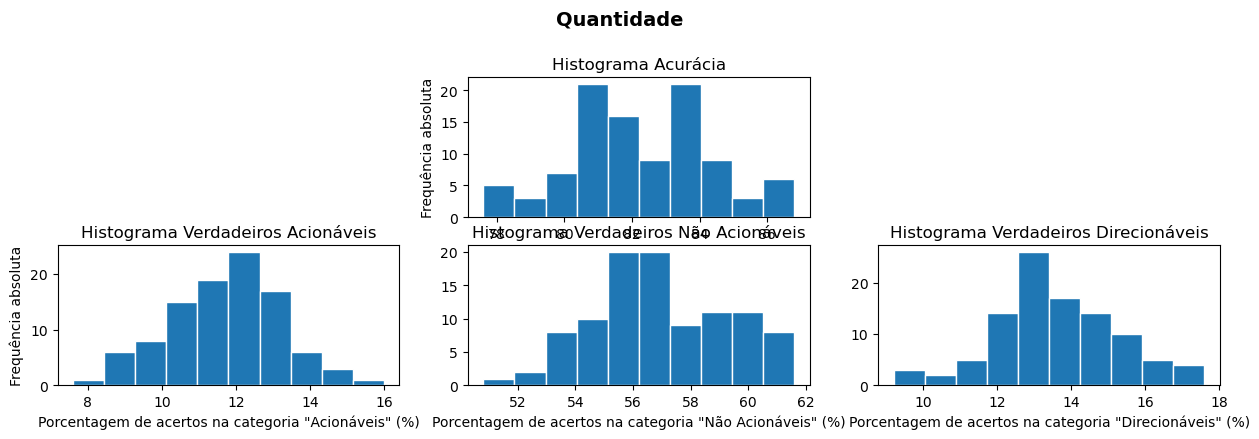

In [181]:

tamanho_fonte = 14
peso_fonte = 600

# Histogramas
plt.figure(figsize=(15, 4))
plt.suptitle('Quantidade',fontsize=tamanho_fonte, fontweight=peso_fonte, y=1.05)


plt.subplot(232) # Janela gráfica com 1 linha, 2 colunas e histograma a seguir é colocado na posição 1
plt.hist(dados_calculados["Acurácia"], edgecolor='white') 
plt.title("Histograma Acurácia")
plt.xlabel('Porcentagem de acertos (%)')
plt.ylabel('Frequência absoluta')


plt.subplot(234) # Janela gráfica com 1 linha, 2 colunas e histograma a seguir é colocado na posição 1
plt.hist(dados_calculados["Verdadeiros Acionáveis"], edgecolor='white') 
plt.title("Histograma Verdadeiros Acionáveis")
plt.xlabel('Porcentagem de acertos na categoria "Acionáveis" (%)')
plt.ylabel('Frequência absoluta')

plt.subplot(235) # Janela gráfica com 1 linha, 2 colunas e histograma a seguir é colocado na posição 1
plt.hist(dados_calculados["Verdadeiros Não Acionáveis"], edgecolor='white') 
plt.title("Histograma Verdadeiros Não Acionáveis")
plt.xlabel('Porcentagem de acertos na categoria "Não Acionáveis" (%)')
#plt.ylabel('Frequência absoluta')

plt.subplot(236) # Janela gráfica com 1 linha, 2 colunas e histograma a seguir é colocado na posição 1
plt.hist(dados_calculados["Verdadeiros Direcionáveis"], edgecolor='white') 
plt.title("Histograma Verdadeiros Direcionáveis")
plt.xlabel('Porcentagem de acertos na categoria "Direcionáveis" (%)')
#plt.ylabel('Frequência absoluta')


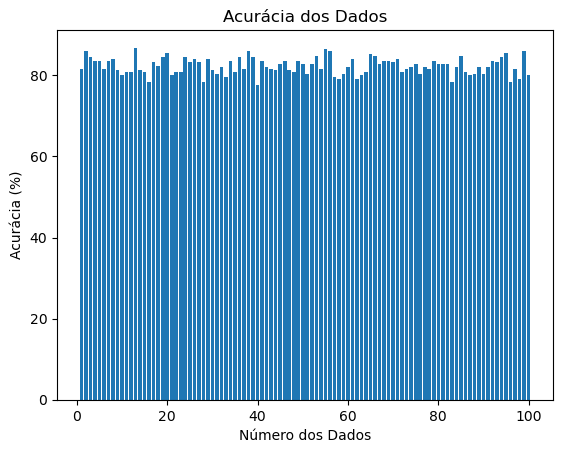

In [182]:
numeros_de_dados = list(range(1, len(acuracia) + 1))

# Crie o gráfico de barras
plt.bar(numeros_de_dados, acuracia)
plt.xlabel('Número dos Dados')
plt.ylabel('Acurácia (%)')
plt.title('Acurácia dos Dados')
plt.show()

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords
* CONSIDEROU mais de duas categorias na variável Target e INCREMENTOU a quantidade de notícias, mantendo pelo menos 250 notícias por categoria (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* Para Target com duas categorias: CRIOU pelo menos quatro categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item Qualidade do Classificador a partir de novas separações das Notícias entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**

Dica: apresentar um grafico com testes mostrando quais limpezas melhoraram a acurácia do nosso classificador (lemmatization, stopwords, etc)

REtirar algumas palavras para ver se melhora a qualidade do classificador (exemplo palavra não)